# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch

In [6]:
import numba.cuda

In [7]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [8]:
decoys = tmol.tests.data.structures_bysize()

In [11]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame

def benchmark_rosetta_scores(decoys):
    stats = []
    
    for n, d in decoys.items():
        logging.info(n)
        work_pose = d.stripped_pose.pose
        
        fixture = make_fixture("score", stats.append, nres=len(work_pose.residues), model = n)
        
        logging.info("Rosetta")
        #fsf = pyrosetta.get_score_function()
        #def rosetta_noclear():
        #    return fsf(work_pose)
        #
        #def rosetta_clear():
        #    work_pose.energies().clear()
        #    return fsf(work_pose)
        #
        #null_sf = pyrosetta.get_score_function()
        #for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        #    null_sf.set_weight(v, 0)
        #
        #def rosetta_null():
        #    work_pose.energies().clear()
        #    return null_sf(work_pose)
        #
        #def rosetta_full():
        #    work_pose.energies().clear_energies()
        #    return fsf(work_pose)
        
        atr_rep_sf = pyrosetta.get_score_function()
        for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
            if k not in ("fa_atr", "fa_rep"):
                atr_rep_sf.set_weight(v, 0)
                
        @subfixture(fixture) 
        def rosetta_atr_rep():
            work_pose.energies().clear()
            return atr_rep_sf(work_pose)
        
        @reactive_attrs
        class TMolLJLK(
            tmol.score.ljlk.LJLKScoreGraph,
            tmol.score.interatomic_distance.BlockedInteratomicDistanceGraph,
            tmol.score.coordinates.CartesianAtomicCoordinateProvider,
            tmol.score.bonded_atom.BondedAtomScoreGraph,
            tmol.score.device.TorchDevice,
        ):
            pass
        
        @reactive_attrs
        class TMolJitLJLK(
            tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
            tmol.score.coordinates.CartesianAtomicCoordinateProvider,
            tmol.score.bonded_atom.BondedAtomScoreGraph,
            tmol.score.device.TorchDevice,
        ):
            pass
        
        score_graphs = dict(
            tmol_lj_cpu = TMolLJLK.build_for(d.tmol_system, requires_grad=False),
            tmol_lj_cpu_jit = TMolJitLJLK.build_for(d.tmol_system, requires_grad=False),
            tmol_lj_cuda = TMolLJLK.build_for(d.tmol_system, device=torch.device("cuda"), requires_grad=False),
            tmol_lj_cuda_jit = TMolJitLJLK.build_for(d.tmol_system, device=torch.device("cuda"), requires_grad=False),
        )
        
        scores = {}
        
        for n, sg in score_graphs.items():
            # Bypass errors w/ cuda memory
            if len(work_pose.residues) > 500 and n is "tmol_lj_cuda":
                continue

            logging.info(f"{n}")
            # Setup graph
            sg.intra_score().total_lj
            
            @make_subfixture(fixture, f".{n}")
            def benchmark_score_graph():
                sg.coords = sg.coords
                return float(sg.intra_score().total_lj)
            
            scores[n] = benchmark_score_graph
            
        del score_graphs
        torch.cuda.empty_cache()
        
        tmol_scores = " ".join(f"{n}: {v}" for n, v in scores.items())
        
        logging.info(f"rosetta: {rosetta_atr_rep} {tmol_scores}")
        
    return stats

In [12]:
rosetta_score_results = benchmark_rosetta_scores(decoys)

INFO:root:BYSIZE_400_RES_6AZU
INFO:root:Rosetta
INFO:root:tmol_lj_cpu
INFO:root:tmol_lj_cpu_jit
INFO:root:tmol_lj_cuda
INFO:root:tmol_lj_cuda_jit
INFO:numba.cuda.cudadrv.driver:init
INFO:root:rosetta: -1653.4115141856676 tmol_lj_cpu: 710.3541870117188 tmol_lj_cpu_jit: 1420.70849609375 tmol_lj_cuda: 710.3544311523438 tmol_lj_cuda_jit: 1420.7083740234375
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:Rosetta
INFO:root:tmol_lj_cpu
INFO:root:tmol_lj_cpu_jit
INFO:root:tmol_lj_cuda
INFO:root:tmol_lj_cuda_jit
INFO:root:rosetta: -954.3679023401932 tmol_lj_cpu: -690.8179321289062 tmol_lj_cpu_jit: -1381.6358642578125 tmol_lj_cuda: -690.8179321289062 tmol_lj_cuda_jit: -1381.6358642578125
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:Rosetta
INFO:root:tmol_lj_cpu
INFO:root:tmol_lj_cpu_jit
INFO:root:tmol_lj_cuda
INFO:root:tmol_lj_cuda_jit
INFO:root:rosetta: -1119.8932213914081 tmol_lj_cpu: -716.1953735351562 tmol_lj_cpu_jit: -1432.3907470703125 tmol_lj_cuda: -716.1953125 tmol_lj_cuda_jit: -1432.390625
INFO:root

In [13]:
from matplotlib import pyplot
import seaborn
import pandas

In [14]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'").groupby("model").time.mean().rename("rosetta_mean").to_frame(),
            left_on="model",
            right_index=True
        ).eval("time / rosetta_mean").rename("rosetta_relative")
    ),
    axis=1
)

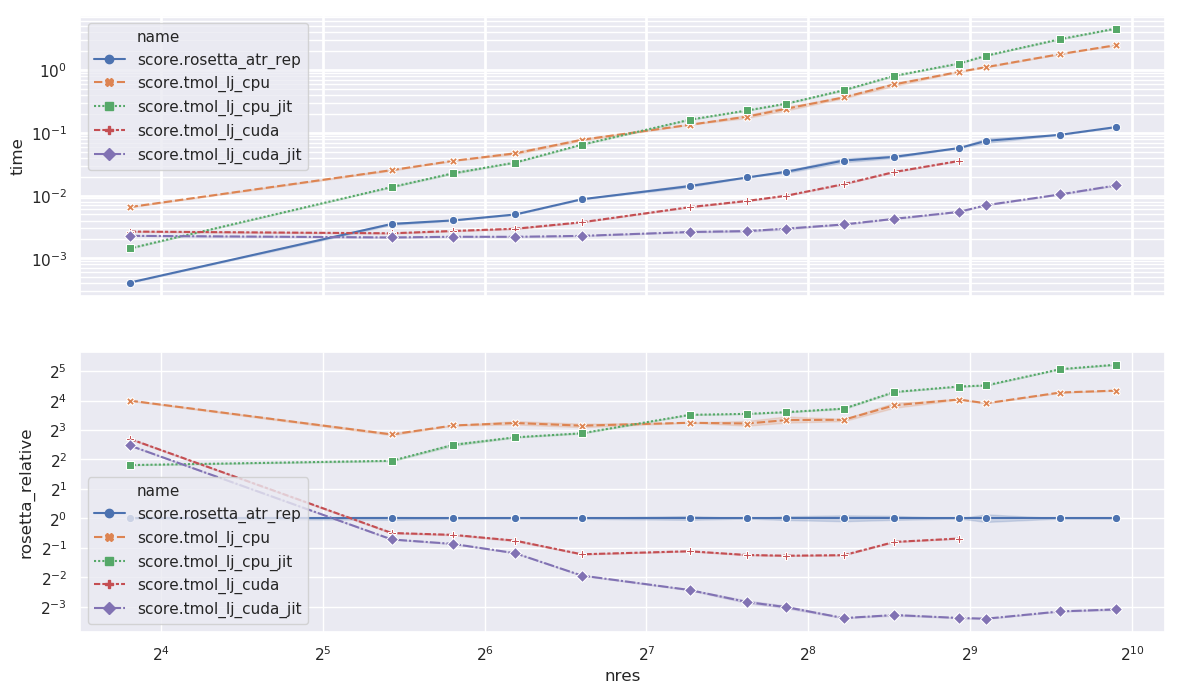

In [15]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", style="name", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "rosetta_relative", data=dat, hue="name", style="name", markers=True)

In [20]:
(
    dat.query("name=='score.tmol_lj_cuda_jit'")
    .groupby("nres")[["rosetta_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

mean                        max                        std  \
     rosetta_relative      time rosetta_relative      time rosetta_relative   
nres                                                                          
14           5.566211  0.002280         8.836955  0.003619         0.188959   
43           0.609367  0.002149         0.762881  0.002691         0.013244   
56           0.548276  0.002203         0.624994  0.002511         0.018259   
73           0.440809  0.002200         0.499187  0.002491         0.008304   
97           0.260673  0.002274         0.508119  0.004434         0.013690   
154          0.185467  0.002624         0.392423  0.005551         0.015178   
197          0.139705  0.002715         0.824739  0.016025         0.041455   
233          0.123862  0.002966         0.592213  0.014180         0.035861   
298          0.095793  0.003461         0.160273  0.005791         0.004441   
370          0.102918  0.004255         0.189198  0.007823         0.010465   
488          0.096062  0.005489         0.102479  0.005856         0.000977   
548          0.094427  0.007020         0.099018  0.007362         0.001750   
753          0.112083  0.010434         0.120814  0.011247         0.002539   
956          0.117423  0.014504         0.181589  0.022430         0.008548   

                
          time  
nres            
14    0.000077  
43    0.000047  
56    0.000073  
73    0.000041  
97    0.000119  
154   0.000215  
197   0.000805  
233   0.000859  
298   0.000160  
370   0.000433  
488   0.000056  
548   0.000130  
753   0.000236  
956   0.001056